In [1]:
import kagglehub
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

def asignar_etiqueta(fila):
    # Asignar una etiqueta según la clase de la lesión
    if fila['MEL'] == 1.0:
        return 1  # MEL - melanoma
    elif fila['BCC'] == 1.0:
        return 2  # BCC - carcinoma basocelular
    elif fila['AKIEC'] == 1.0:
        return 3  # AKIEC - lesión precancerosa
    else:
        return 0  # Sin cáncer

IMG_SIZE = (224, 224)  # Tamaño de las imágenes

def procesar_imagen(ruta_archivo, etiqueta):
    # Leer la imagen desde el archivo
    img = tf.io.read_file(ruta_archivo)
    img = tf.image.decode_jpeg(img, channels=3)  # Decodificar imagen en RGB

    # Preprocesar la imagen (redimensionar y normalizar)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0  # Normalizar a [0, 1]

    # Convertir la etiqueta a one-hot encoding
    etiqueta = tf.one_hot(etiqueta, 4)  # 4 clases
    return img, etiqueta

BATCH_SIZE = 32        # Tamaño del batch para el entrenamiento

def configurar_para_rendimiento(df):
    # Optimizar el dataframe para el rendimiento
    df = df.cache()  # Guardar en cache
    df = df.shuffle(buffer_size=1000)  # Barajar los datos
    df = df.batch(BATCH_SIZE)  # Batching de datos(por lotes)
    return df

# Comprobación si el dataset ya está descargado
ruta_base = '/root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2'
if not os.path.exists(ruta_base):
    print("Dataset no encontrado. Descargando el dataset...")
    # Descargar el dataset desde Kaggle
    ruta = kagglehub.dataset_download("surajghuwalewala/ham1000-segmentation-and-classification")
else:
    print("Dataset ya descargado.")


Dataset no encontrado. Descargando el dataset...


100%|██████████| 2.59G/2.59G [00:30<00:00, 91.0MB/s]

Extracting files...


In [2]:

# Cargar los metadatos y las rutas de las imágenes
directorio_imagenes = f"{ruta_base}/images/"
metadata = pd.read_csv(f'{ruta_base}/GroundTruth.csv')

# Asignar etiquetas a las imágenes
metadata['label'] = metadata.apply(asignar_etiqueta, axis=1)

metadata['ruta_imagenes'] = metadata['image'].apply(lambda x: f"{directorio_imagenes}/{x}.jpg")

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
df_entrenamiento, df_prueba = train_test_split(metadata, test_size=0.2, stratify=metadata['label'], random_state=42)

# Crear dataframes de TensorFlow para entrenamiento y prueba
df_entrenamiento = tf.data.Dataset.from_tensor_slices((
    df_entrenamiento['ruta_imagenes'].values,
    df_entrenamiento['label'].values
))
df_prueba = tf.data.Dataset.from_tensor_slices((
    df_prueba['ruta_imagenes'].values,
    df_prueba['label'].values
))



In [3]:

# Aplicar el procesamiento de imágenes
df_entrenamiento = df_entrenamiento.map(procesar_imagen)
df_prueba = df_prueba.map(procesar_imagen)

# Configurar los dataframes para rendimiento
df_entrenamiento = configurar_para_rendimiento(df_entrenamiento)
df_prueba = configurar_para_rendimiento(df_prueba)

# Crear el modelo con MobileNetV2 como base
modelo_base = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),   # Tamaño de las imágenes de entrada
    include_top=False,           # No incluir la capa superior (solo la base)
    weights='imagenet'           # Usar pesos preentrenados de ImageNet
)
modelo_base.trainable = False  # No entrenar la base de MobileNetV2

# Crear un modelo secuencial
modelo = tf.keras.Sequential([
    modelo_base,
    tf.keras.layers.GlobalAveragePooling2D(),  # Promedio global de las características
    tf.keras.layers.Dense(128, activation='relu'),  # Capa densa de 128 neuronas
    tf.keras.layers.Dropout(0.3),  # Dropout para evitar sobreajuste
    tf.keras.layers.Dense(4, activation='softmax')  # Capa de salida con 4 clases
])

# Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Usar cross-entropy para clasificación multiclase
    metrics=['accuracy']  # Métrica de precisión
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Entrenar el modelo
historial = modelo.fit(
    df_entrenamiento,
    validation_data=df_prueba,
    epochs=10  # Número de vueltas
)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 88s 285ms/step - accuracy: 0.7829 - loss: 0.6763 - val_accuracy: 0.8083 - val_loss: 0.5626
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 41ms/step - accuracy: 0.8213 - loss: 0.4857 - val_accuracy: 0.8258 - val_loss: 0.4582
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8239 - loss: 0.4621 - val_accuracy: 0.8288 - val_loss: 0.4656
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.8344 - loss: 0.4314 - val_accuracy: 0.8362 - val_loss: 0.4452
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8441 - loss: 0.4017 - val_accuracy: 0.8313 - val_loss: 0.4441
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.8485 - loss: 0.3927 - val_accuracy: 0.8352 - val_loss: 0.4479
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.8529 - loss: 0.3770 - val_accuracy: 0.8337 - val_loss: 0.4401
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.8594 - loss: 0.3524 -

In [7]:
# Montar Drive
from google.colab import drive
drive.mount('/content/drive')

# Ruta donde guardo el modelo
ruta_guardado = "/content/drive/MyDrive/modelo_deteccion_cancer.keras"

# Guardar el modelo en la ruta
modelo.save(ruta_guardado)

print(f"Modelo guardado en: {ruta_guardado}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelo guardado en: /content/drive/MyDrive/modelo_deteccion_cancer.keras


Por favor, sube una imagen para clasificar


Saving lunarron.jpeg to lunarron (3).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


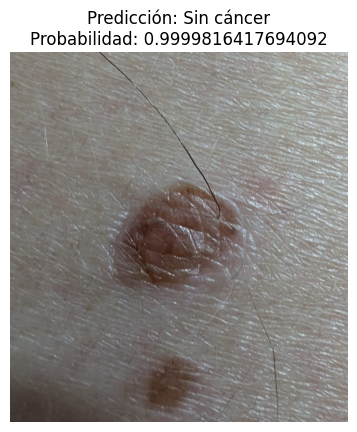

In [14]:
from google.colab import files  # Para subir archivos en Google Colab
import numpy as np  # Para trabajar con números y arrays
from PIL import Image  # Para abrir y manipular imágenes
import matplotlib.pyplot as plt  # Para mostrar imágenes y gráficos

# Función para preparar la imagen antes de pasarla al modelo
def preparar_imagen(ruta_imagen, tamaño=(224, 224)):
    # Abrir la imagen
    img = Image.open(ruta_imagen)

    # Redimensionar la imagen al tamaño que el modelo espera (224x224 píxeles)
    img = img.resize(tamaño)

    # Convertir la imagen a un array de números (para que el modelo pueda usarla)
    img_array = np.array(img)

    # Normalizar los valores de los píxeles (originalmente van de 0 a 255, los convertimos a 0-1)
    img_array = img_array / 255.0

    # Añadir una dimensión extra para que el modelo pueda procesarla (el modelo espera un lote de imágenes)
    #Los modelos de deep learning esperan que las imágenes tengan la forma (batch_size, height, width, channels),
    #donde batch_size es el número de imágenes. Si solo pasamos una imagen, su forma sería (height, width, channels),
    #y el modelo no la entendería. Por eso, usamos np.expand_dims para agregar una dimensión al principio, convirtiendo
    #la forma a (1, height, width, channels). Esto le dice al modelo que es un lote de una sola imagen, permitiéndole procesarla correctamente.

    img_array = np.expand_dims(img_array, axis=0)  # Forma: (1, 224, 224, 3)

    #axis=0: Indica que queremos agregar la dimensión en la primera posición (el batch_size).

    return img_array

# Función para predecir la clase de la imagen
def predecir_imagen(ruta_imagen):
    # Preparar la imagen usando la función que definimos
    img_array = preparar_imagen(ruta_imagen)

    # Usar el modelo para predecir la clase de la imagen
    predicciones = modelo.predict(img_array)

    # Obtener la clase predicha (el número con la probabilidad más alta)
    clase_predicha = np.argmax(predicciones, axis=1)[0]

    # Obtener la probabilidad de la clase predicha (qué tan seguro está el modelo)
    probabilidad = np.max(predicciones)

    return clase_predicha, probabilidad

# Función para mostrar la imagen y el resultado de la predicción
def mostrar_resultado(ruta_imagen, clase_predicha, probabilidad):
    # Diccionario para convertir el número de la clase a un nombre que podamos entender
    clases = {
        0: "Sin cáncer",
        1: "Melanoma (MEL)",
        2: "Carcinoma basocelular (BCC)",
        3: "Lesión precancerosa (AKIEC)"
    }

    # Obtener el nombre de la clase predicha usando el diccionario
    nombre_clase = clases.get(clase_predicha, "Desconocido")

    # Abrir la imagen para mostrarla
    img = Image.open(ruta_imagen)

    # Mostrar la imagen
    plt.imshow(img)
    plt.axis('off')  # Ocultar los ejes

    # Mostrar el título con la predicción y la probabilidad
    plt.title(f"Predicción: {nombre_clase}\nProbabilidad: {probabilidad}")

    # Mostrar la imagen en pantalla
    plt.show()

# Subir una imagen
print("Por favor, sube una imagen para clasificar")
uploaded = files.upload()

# Obtener el nombre del archivo subido
ruta_imagen_subida = list(uploaded.keys())[0]  # Tomamos el nombre del primer archivo subido

# Predecir la clase de la imagen usando la función que definimos
clase_predicha, probabilidad = predecir_imagen(ruta_imagen_subida)

# Mostrar la imagen y el resultado de la predicción
mostrar_resultado(ruta_imagen_subida, clase_predicha, probabilidad)